In [1]:
#Project Imports

import pandas as pd
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from functools import reduce

import requests



from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import neighbors


from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features.importances import FeatureImportances

from sodapy import Socrata



from functools import reduce
from datetime import timezone, datetime,date
import pytz

pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')
%matplotlib inline

# Load bike data from Seattle data API

In [2]:

socrata_domain = 'data.seattle.gov'
socrata_dataset_identifier = '65db-xm6k'
socrata_token  = 'uTBE5rW06JBkufq8UsBellVPy'

client = Socrata(socrata_domain, socrata_token)

results = client.get(socrata_dataset_identifier 
                     ,where= "Date >= '2010-11-01T03:00:00.000' "
                     ,limit = 100000
                    )
fremont = pd.DataFrame.from_records(results)

In [3]:
#Convert date column and set as index

fremont['date'] = pd.to_datetime(fremont.date)
fremont.set_index('date',inplace = True)
fremont.index.names =['Date_Join']

#Convert to numeric columns
fremont['fremont_bridge_nb'] = pd.to_numeric(fremont['fremont_bridge_nb'])
fremont['fremont_bridge_sb'] = pd.to_numeric(fremont['fremont_bridge_sb'])


#Set timezone and sort index
fremont = fremont.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
fremont.sort_index(inplace = True)

#rename
fremont.rename(columns = {'fremont_bridge_nb' : 'EastSide',
                         'fremont_bridge_sb':'WestSide'
                         } , inplace= True)

#FillNA values with mean
fremont['WestSide'].fillna(value = fremont['WestSide'].mean(),inplace = True)
fremont['EastSide'].fillna(value = fremont['EastSide'].mean(),inplace = True)


#calculated Columns
fremont['Mean_Xing'] = fremont[['WestSide','EastSide']].mean(axis=1)
fremont['Total_Xing'] = fremont[['EastSide','WestSide']].sum(axis=1)
fremont['Time_of_Day'] = fremont.index.strftime('%H')
fremont['Month'] = fremont.index.strftime('%m')



print('You have Bridge data from {} to {}'.format(fremont.index.min().strftime('%m/%d/%Y-%I%p'),fremont.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(fremont.shape[0],fremont.shape[1]))
print(fremont.dtypes)

You have Bridge data from 10/03/2012-12AM to 05/31/2019-11PM
There are 58368 observations and 6 columns
EastSide       float64
WestSide       float64
Mean_Xing      float64
Total_Xing     float64
Time_of_Day     object
Month           object
dtype: object


In [4]:
# Resample Bike to Daily
fremont_d = fremont.resample('D').sum()
fremont_d['Month'] = fremont_d.index.strftime('%m')
fremont_d['WeekDay'] = fremont_d.index.strftime('%A')

# Load WX data

In [5]:
path = "./Data/Daily_Summaries/Daily_Summaries_Merged.csv"
d = ","
wx = pd.read_csv(path,delimiter=d)
wx.DATE = pd.to_datetime(wx.DATE)
wx.rename(columns={'DATE':'Date_Join'},inplace = True)
wx.drop(['LATITUDE','LONGITUDE'],axis = 1,inplace=True)
#FillNA values with mean
wx['TMAX'].fillna(value = wx['TMAX'].mean(),inplace = True)
wx['TMIN'].fillna(value = wx['TMIN'].mean(),inplace = True)
;

''

In [6]:
#Rename Stations
wx.loc[wx['STATION'] == 'USW00024233', 'NAME'] = 'SeaTac'
wx.loc[wx['STATION'] == 'USW00024234', 'NAME'] = 'Boeing_Field'
wx.loc[wx['STATION'] == 'US1WAKG0079', 'NAME'] = 'Magnolia'
wx.loc[wx['STATION'] == 'US1WAKG0145', 'NAME'] = 'Phinney'
wx.loc[wx['STATION'] == 'US1WAKG0200', 'NAME'] = 'Georgetown'
wx.loc[wx['STATION'] == 'US1WAKG0199', 'NAME'] = 'GreenWood'
wx.loc[wx['STATION'] == 'US1WAKG0225', 'NAME'] = 'Cap_Hill'
wx.loc[wx['STATION'] == 'US1WAKG0239', 'NAME'] = 'Woodland_Park'

In [7]:
#average WX observations together to get daily totals
wx_d = wx.groupby(by = 'Date_Join')[['PRCP','TMAX','TMIN']].mean()

wx_d = wx_d.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')

#Define Rain Day
wx_d['Rain_Day'] = (wx_d['PRCP'] > .1)

print('You have WX data from {} to {}'.format(wx_d.index.min().strftime('%m/%d/%Y-%I%p'),wx_d.index.max().strftime('%m/%d/%Y-%I%p')))

You have WX data from 01/01/2010-12AM to 05/15/2019-12AM


## Load and transform Forecast Test

In [8]:
path = "./Data/Bike_Counts/Forecast_Test.csv"
d = ","
Forecast = pd.read_csv(path,delimiter=d)
Forecast.Date = pd.to_datetime(Forecast.Date)
Forecast.rename(columns={'Date':'Date_Join'},inplace = True)

#Forecast.set_index('Date_Join',inplace=True)
#Forecast = Forecast.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
Forecast['Date_Join'].dt.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')

Forecast['Rain_Day'] = (Forecast['PRCP'] > .1)

Forecast['Month'] = Forecast['Date_Join'].dt.strftime('%m')
Forecast['WeekDay'] = Forecast['Date_Join'].dt.strftime('%A')

Forecast = pd.get_dummies(data=Forecast, columns = ['Month','Rain_Day','WeekDay'])

#Need all the same column headers. The remaining 11 months and 6 weekdays...
#wx_d.columns.difference(nov.columns)


### Merge Bicycle counts and daily weather. Prepare Forecast Test

In [9]:
data = fremont_d.merge(wx_d, how = 'inner',left_on = 'Date_Join',right_on = 'Date_Join')
data = pd.get_dummies(data=data, columns = ['Month','Rain_Day','WeekDay'])

In [10]:
#Create dataframe of actual values for forecast test
Forecast_Actual = data.loc[(data.index.month==11)&(data.index.day==23),['Total_Xing','PRCP','TMAX','TMIN']]
Forecast_Actual= Forecast_Actual.append(data.loc[(data.index.month==7)&(data.index.day==15),['Total_Xing','PRCP','TMAX','TMIN']])
Forecast_Actual= Forecast_Actual.append(data.loc[(data.index.month==8)&(data.index.day==12),['Total_Xing','PRCP','TMAX','TMIN']])
Forecast_Actual= Forecast_Actual.append(data.loc[(data.index.month==10)&(data.index.day==31),['Total_Xing','PRCP','TMAX','TMIN']])
Forecast_Actual= Forecast_Actual.append(data.loc[(data.index.month==9)&(data.index.day==10),['Total_Xing','PRCP','TMAX','TMIN']])
Forecast_Actual= Forecast_Actual.append(data.loc[(data.index.month==11)&(data.index.day==10),['Total_Xing','PRCP','TMAX','TMIN']])
Forecast_Actual= Forecast_Actual.append(data.loc[(data.index.month==10)&(data.index.day==2),['Total_Xing','PRCP','TMAX','TMIN']])

Forecast_Actual['Date_Join'] = Forecast_Actual.index.strftime('2019-%m-%d')
Forecast_Actual['Date_Join'] =pd.to_datetime(Forecast_Actual['Date_Join'] )
Forecast_Actual['Date_Join'].dt.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
Forecast_Actual.rename(columns = {'Total_Xing' : 'Predicted_Crossing'},inplace=True)
Forecast_Actual['Flag'] = 1
#Forecast_Actual.head(50)

In [11]:
#Make columns match for Forecast test
missing_cols = set( data.columns ) - set( Forecast.columns )
for c in missing_cols:
    Forecast[c] = 0


### Correlation Plot

''

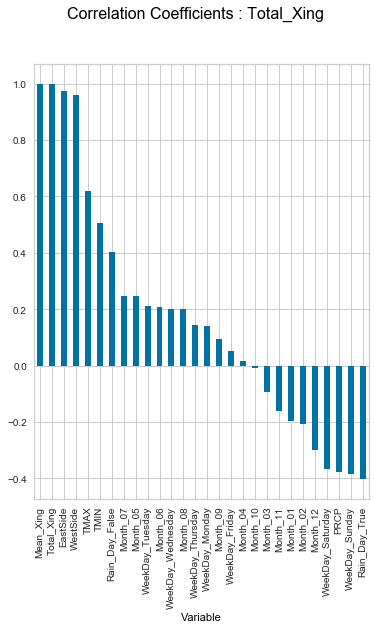

In [12]:

fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [6,8],)
corr = data.corr()
corr['Total_Xing'].sort_values(ascending=False).plot(kind='bar',ax=ax)
ax.set_xlabel("Variable", color="black")
#ax.set_xlabel("Correlation Coefficient", color="black")
fig.suptitle('Correlation Coefficients : Total_Xing', fontsize=16,color='black')
plt.savefig('./Figures/Daily_Coefficients.png')
;

# Select Features and split data

In [13]:
features = [
    'PRCP',
    'TMAX',
    'TMIN', 
    'Month_01',
    'Month_02',
    'Month_03',
    'Month_04',
    'Month_05',
    'Month_06',
    'Month_07',
    'Month_08',
    'Month_09',
    'Month_10',
    'Month_11',
    'Month_12',
    'Rain_Day_False',
    'Rain_Day_True',
    'WeekDay_Monday',
    'WeekDay_Tuesday',
    'WeekDay_Wednesday',
    'WeekDay_Thursday',
    'WeekDay_Friday',
    'WeekDay_Saturday',
    'WeekDay_Sunday'
]

In [14]:
X = data[features]
X_forecast= Forecast[features]


#y = data['EastSide']
#y = data['WestSide']
#y = data['Mean_Xing']
y = data['Total_Xing']


scaler = StandardScaler()
X_std = scaler.fit_transform(X)

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y) #,random_state= 23
#X_train, X_test, y_train, y_test = train_test_split(X_std, y,random_state= 23)


#y_baseline = [data.EastSide.mean()] * len(y_test)
#y_baseline = [data.WestSide.mean()] * len(y_test)
#y_baseline = [data.Mean_Xing.mean()] * len(y_test)
y_baseline = [data.Total_Xing.mean()] * len(y_test)


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

print(len(y_baseline))

(1812, 24)
(1812,)
(604, 24)
(604,)
604


# Fit Model and Analyze

In [16]:
model = Ridge(alpha=5)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
y_pred_forecast = model.predict(X_forecast)


#save model coeficients
coef = Series(model.coef_,features).sort_values(ascending=False)



print("R-squared = ", model.score(X_test, y_test)) 
print("RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print("Baseline RMSE = ",np.sqrt(metrics.mean_squared_error(y_test, y_baseline)))

R-squared =  0.8380710368247598
RMSE =  521.2516707004944
Baseline RMSE =  1295.386385050739


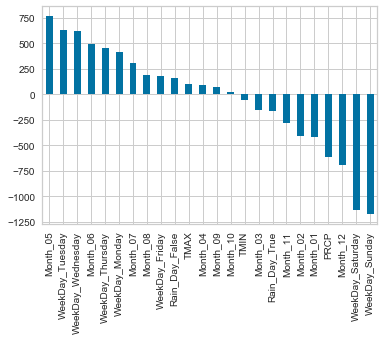

In [17]:
coef.plot(kind='bar')

In [18]:
y_pred_forecast=pd.DataFrame(y_pred_forecast,index=Forecast.index)
y_pred_forecast.rename(columns={y_pred_forecast.columns[0]:'Predicted_Crossing'}, inplace=True)
future = pd.merge(y_pred_forecast,Forecast,left_index=True, right_index=True)
future= future[['Date_Join','Predicted_Crossing','PRCP','Flag','TMAX','TMIN']].sort_values(by=['Date_Join','PRCP'])

In [19]:
x=pd.concat([future,Forecast_Actual])

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


''

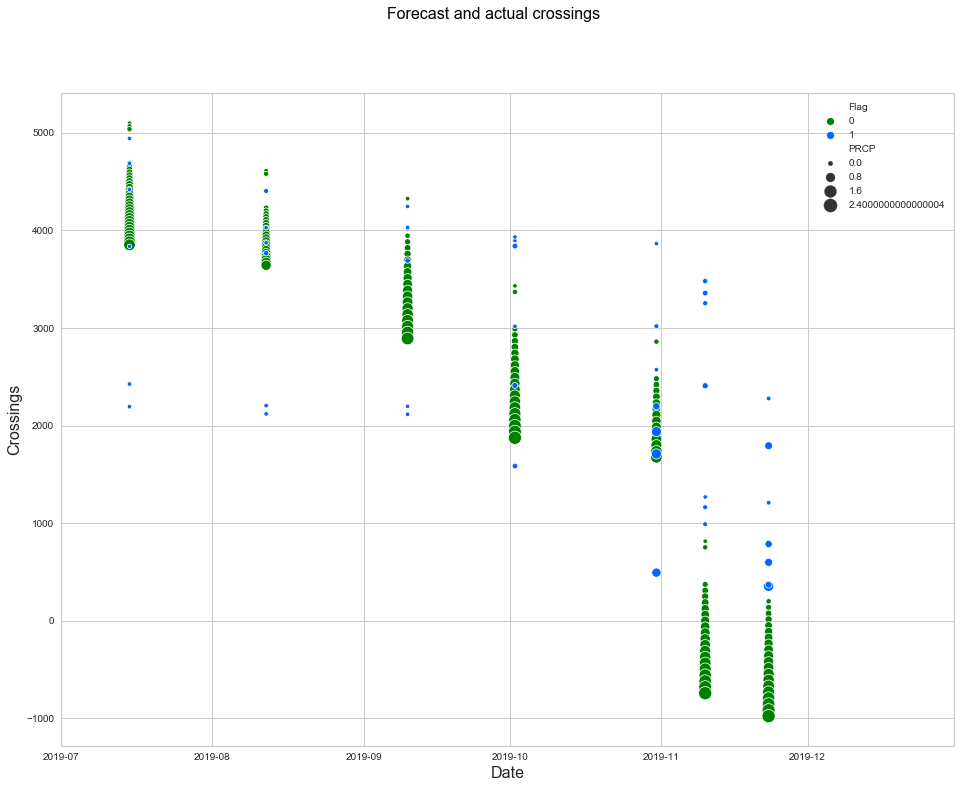

In [20]:
fig, ax = plt.subplots(figsize=(16,12))

sns.scatterplot(x='Date_Join', 
                y="Predicted_Crossing", 
                data=x,
                size='PRCP',
                sizes=(20, 175),
                hue='Flag',
                legend='brief',    
                palette=['#008000','#0066ff'],
                ax = ax
                     )
ax.set_xlim('7/1/2019', '12/31/2019')
ax.set_ylabel('Crossings',fontsize=16)
ax.set_xlabel('Date',fontsize=16)
fig.suptitle('Forecast and actual crossings', fontsize=16,color='black')
plt.savefig('./Figures/Forecast_Scatter.png')

;

''

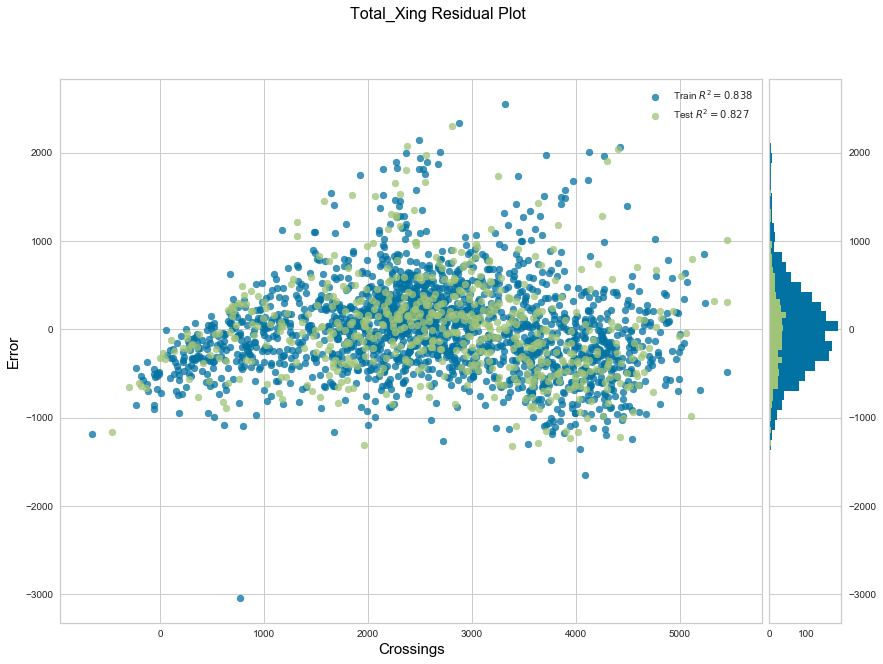

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,10])

visualizer = ResidualsPlot(model,ax=ax)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
#visualizer.poof()                 # Draw/show/poof the data



ax.set_xlabel("Crossings", color="black",size=15)
ax.set_ylabel("Error", color="black",size=15)
#ax.xtick.color('red')
fig.suptitle('Total_Xing Residual Plot', fontsize=16,color='black')

plt.legend()

#plt.show(visualizer)
#plt.show(visualizer.poof(ax=ax) )
plt.savefig('./Figures/Residuals_Daily_Total_Xing.png')


#g = visualizer.poof(ax=ax)             # Draw/show/poof the data
;

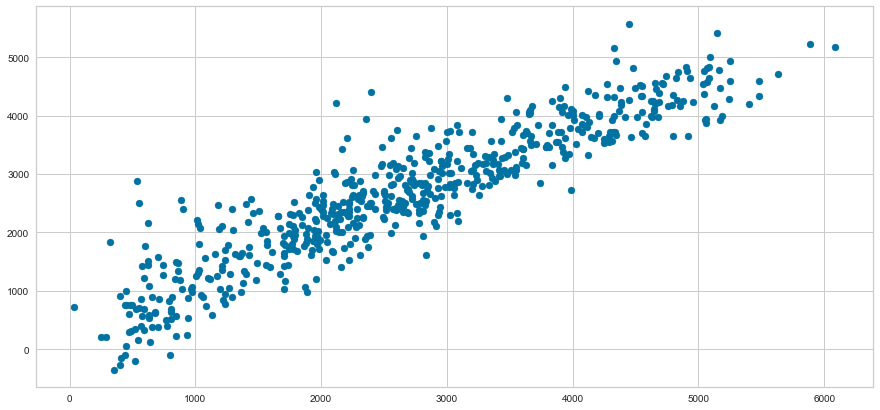

In [21]:
plt.figure(figsize = (15,7))
plt.scatter(x=y_test,y=y_pred, color = 'b')